# Basketball Lineup Progression Analysis
Time-series analysis of lineup performance across the season

In [32]:
# %%

import seaborn as sns
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown, Checkbox

In [33]:
# %%
TEAM_NAME = 'San Francisco'
# Load data
lineup_prog = pd.read_csv(f'{TEAM_NAME}_progression.csv')
top_lineups = pd.read_csv(f'{TEAM_NAME}_top_lineups.csv')

# Round all numeric columns to 2 decimal places
lineup_prog = lineup_prog.round(2)
top_lineups = top_lineups.round(2)
# Convert interval to categorical for proper sorting
lineup_prog['interval_num'] = lineup_prog['interval_num'].astype('category')

In [34]:
display(top_lineups.head(2))

,lineup,possessions,minutes,plusminus,plusminus_per40,netrating,offrating,defrating
0,LLEI-CFUL-EPOR-AZIA-FWER,186.55,110.37,-29,-10.51,-15.55,91.13,106.67
1,LLEI-CFUL-AKÉI-EPOR-FWER,173.40,106.13,32,12.06,18.45,105.53,87.08


In [35]:

# Set up visualization style
plt.style.use('ggplot')  # Using ggplot style instead of seaborn
sns.set_theme(style='whitegrid', palette='husl')
pd.set_option('display.max_columns', None)


## 1. Top Lineups Overview
Key metrics for most used lineups across entire season

In [39]:
if 'top_lineups' in locals():
    styled_top = (
        top_lineups.sort_values('minutes', ascending=False)
        .style
        .background_gradient(subset=['netrating', 'plusminus_per40'], cmap='RdYlGn')
        .format({
            'minutes': '{:.1f}',
            'possessions': '{:.1f}',
            'plusminus': '{:.0f}',
            'plusminus_per40': '{:.1f}',
            'netrating': '{:.1f}',
            'offrating': '{:.1f}',
            'defrating': '{:.1f}'
        })
    )

    display(styled_top)
else:
    print("Top lineups data not available")


,lineup,possessions,minutes,plusminus,plusminus_per40,netrating,offrating,defrating
0,LLEI-CFUL-EPOR-AZIA-FWER,186.6,110.4,-29,-10.5,-15.6,91.1,106.7
1,LLEI-CFUL-AKÉI-EPOR-FWER,173.4,106.1,32,12.1,18.4,105.5,87.1
2,LLEI-CFUL-EPOR-DSAN-FWER,122.7,74.3,28,15.1,22.8,105.1,82.3
3,LLEI-EPAP-EPOR-AZIA-FWER,89.2,52.7,0,0.0,0.0,94.2,94.2
4,LLEI-AKÉI-EPOR-AZIA-FWER,82.7,49.4,4,3.2,4.8,96.7,91.9
5,EPAP-EPOR-AZIA-DSAN-FWER,70.6,37.2,28,30.1,39.7,109.0,69.4
7,LLEI-CFUL-EPAP-AZIA-FWER,48.5,32.0,-13,-16.2,-26.8,78.4,105.2
6,LLEI-EPOR-AZIA-DSAN-FWER,49.1,28.5,18,25.2,36.6,126.2,89.5
9,LLEI-CFUL-AZIA-DSAN-FWER,43.0,28.0,8,11.4,18.6,83.7,65.1
10,LLEI-CFUL-AKÉI-AZIA-FWER,42.3,24.6,-1,-1.6,-2.4,66.2,68.5


# How Lineup Minutes Changed Over the Intervals

In [44]:
if 'lineup_prog' in locals() and 'top_lineups' in locals():
    # Get top 5 lineups by total minutes
    top5_lineups = top_lineups.sort_values('minutes', ascending=False).head(6)['lineup'].tolist()

    # Filter for just those top 5 in the progression data
    top5_prog = lineup_prog[lineup_prog['lineup'].isin(top5_lineups)]

    # Pivot to see how minutes change across intervals
    minute_change_table = top5_prog.pivot_table(
        index='lineup',
        columns='interval',
        values='minutes',
        aggfunc='sum'
    ).fillna(0)

    # Round and display nicely
    display(
        minute_change_table.style
        .format("{:.1f}")
        .background_gradient(cmap="Greens")
        .set_caption("Top 5 Lineups: Minutes by Interval")
    )
else:
    print("Required data not available")


interval,1-10,11-20,21-30
lineup,,,
EPAP-EPOR-AZIA-DSAN-FWER,23.5,13.7,0.0
LLEI-AKÉI-EPOR-AZIA-FWER,0.0,37.1,12.2
LLEI-CFUL-AKÉI-EPOR-FWER,1.0,11.8,93.4
LLEI-CFUL-EPOR-AZIA-FWER,4.0,54.3,52.1
LLEI-CFUL-EPOR-DSAN-FWER,6.4,67.9,0.0
LLEI-EPAP-EPOR-AZIA-FWER,4.0,12.7,36.1


In [19]:
top_12_lineups = lineup_prog.groupby('lineup')['minutes'].sum().nlargest(12).index
#display(lineup_prog)
display(lineup_prog.loc[lineup_prog['lineup'].isin(top_12_lineups), ['lineup', 'minutes','interval','plusminus_per40']].sort_values(by='minutes', ascending=False).head(12))
print('\n')




,lineup,minutes,interval,plusminus_per40
201,LLEI-CFUL-AKÉI-EPOR-FWER,93.39,21-30,11.99
90,LLEI-CFUL-EPOR-DSAN-FWER,67.87,11-20,14.73
109,LLEI-CFUL-EPOR-AZIA-FWER,54.27,11-20,-23.59
226,LLEI-CFUL-EPOR-AZIA-FWER,52.11,21-30,5.37
93,LLEI-AKÉI-EPOR-AZIA-FWER,37.13,11-20,16.16
215,LLEI-EPAP-EPOR-AZIA-FWER,36.08,21-30,-2.22
32,EPAP-EPOR-AZIA-DSAN-FWER,23.53,1-10,11.90
204,LLEI-CFUL-EPAP-AZIA-FWER,21.98,21-30,5.46
26,LLEI-CFUL-AZIA-DSAN-FWER,21.19,1-10,1.89
22,LLEI-EPAP-EPOR-DSAN-FWER,16.39,1-10,-19.52


## 3. Comparative Performance Heatmap
How lineups compare across different game intervals

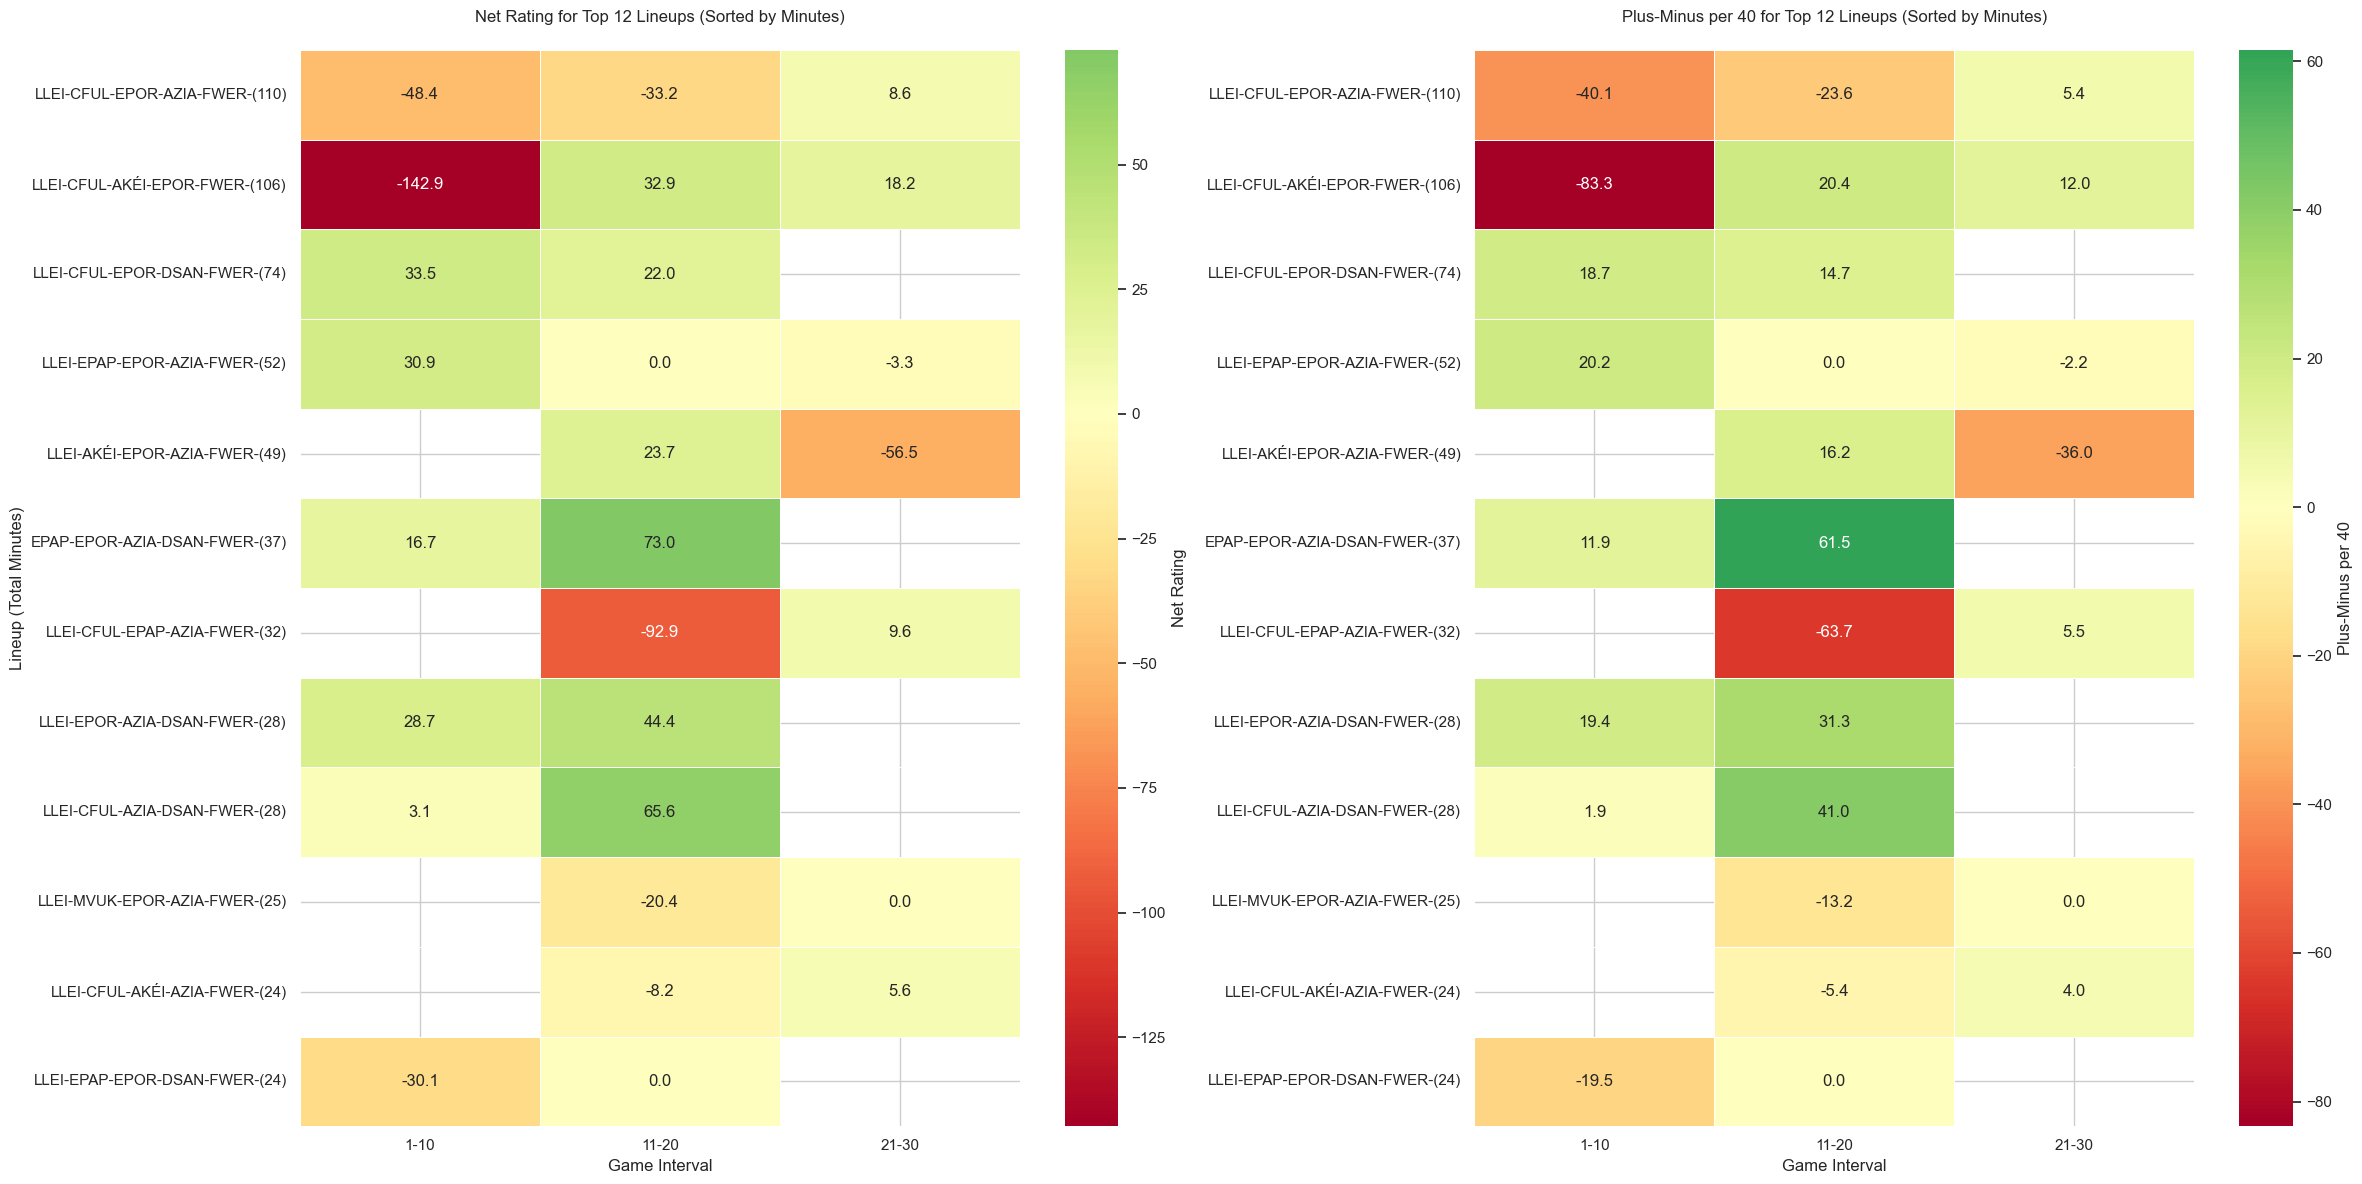

In [20]:
if 'lineup_prog' in locals():
    try:
        # Get top 12 lineups by total minutes played
        lineup_minutes = lineup_prog.groupby('lineup')['minutes'].sum()
        top_12_lineups = lineup_minutes.nlargest(12)

        # Rename lineups to include total minutes (e.g. BW-NE-AC-MH-CH-(120))
        lineup_name_map = {
            lineup: f"{'-'.join([p.upper() for p in lineup.split('-')])}-({int(lineup_minutes[lineup])})"
            for lineup in top_12_lineups.index
        }

        # Filter data and relabel
        top_lineup_data = lineup_prog[lineup_prog['lineup'].isin(top_12_lineups.index)].copy()
        top_lineup_data['lineup_label'] = top_lineup_data['lineup'].map(lineup_name_map)

        # Sort the data by total minutes
        sort_order = [lineup_name_map[lu] for lu in top_12_lineups.index]
        top_lineup_data['lineup_label'] = pd.Categorical(top_lineup_data['lineup_label'], categories=sort_order, ordered=True)

        # Create subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))

        # Net Rating Heatmap
        netrating_data = top_lineup_data.pivot(index='lineup_label', columns='interval', values='netrating')
        sns.heatmap(
            netrating_data,
            annot=True,
            fmt=".1f",
            center=0,
            cmap='RdYlGn',
            linewidths=.5,
            cbar_kws={'label': 'Net Rating'},
            ax=ax1
        )
        ax1.set_title('Net Rating for Top 12 Lineups (Sorted by Minutes)', pad=20)
        ax1.set_xlabel('Game Interval')
        ax1.set_ylabel('Lineup (Total Minutes)')

        # Plus-Minus per 40 Heatmap
        pm40_data = top_lineup_data.pivot(index='lineup_label', columns='interval', values='plusminus_per40')
        sns.heatmap(
            pm40_data,
            annot=True,
            fmt=".1f",
            center=0,
            cmap='RdYlGn',
            linewidths=.5,
            cbar_kws={'label': 'Plus-Minus per 40'},
            ax=ax2
        )
        ax2.set_title('Plus-Minus per 40 for Top 12 Lineups (Sorted by Minutes)', pad=20)
        ax2.set_xlabel('Game Interval')
        ax2.set_ylabel('')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error generating heatmaps: {e}")
else:
    print("Lineup progression data not available")


## Lineup Performance vs Team Averages

  interval  netrating  plusminus_per40
0     1-10 -25.943793       -28.282333
1    11-20   9.132252        11.254144
2    21-30   2.042063         6.293333


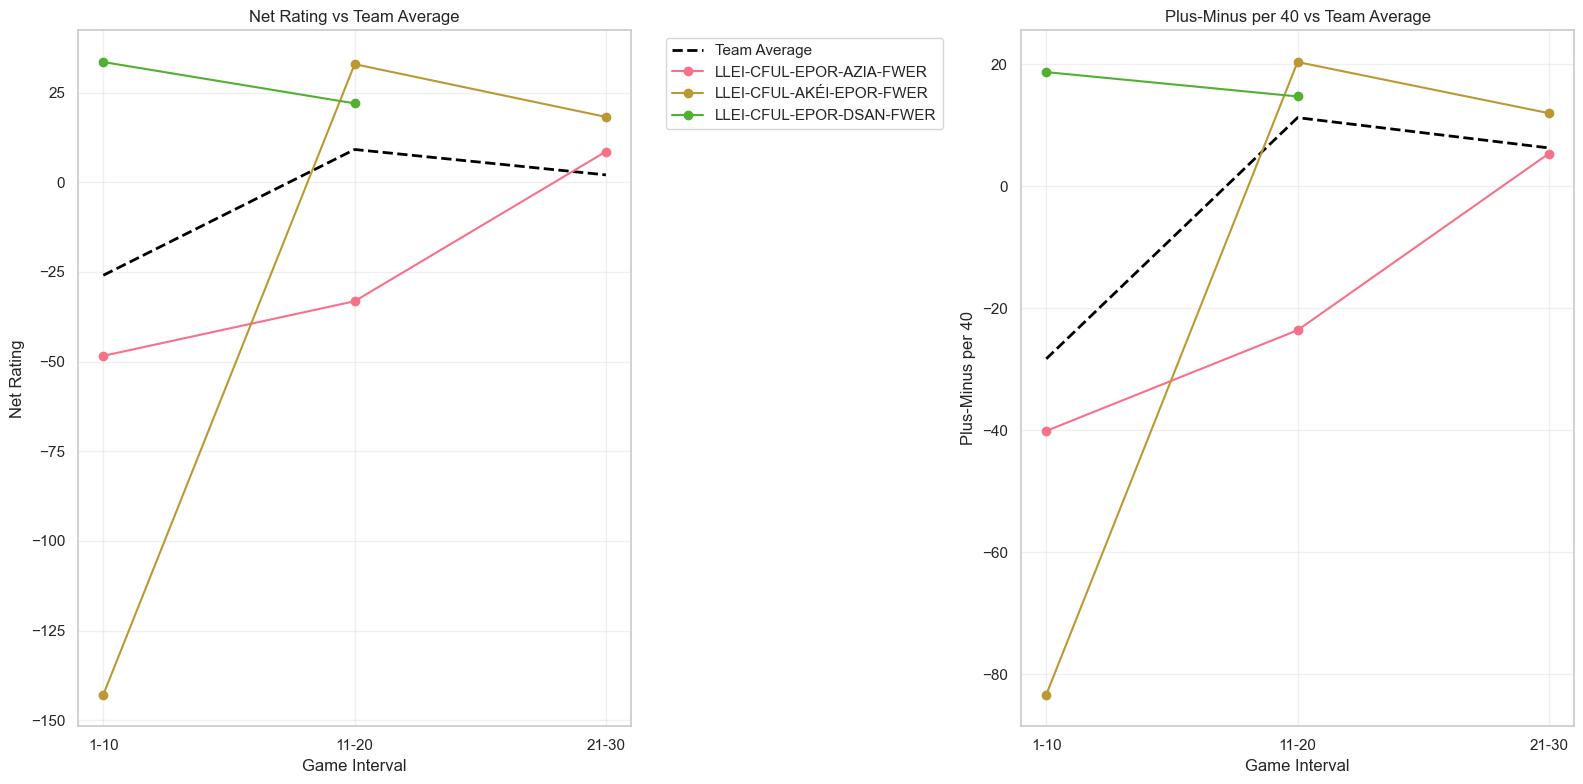

In [21]:

if 'lineup_prog' in locals():
    try:
        # Calculate team averages by interval
        team_avg = lineup_prog.groupby('interval').agg({
            'netrating': 'mean',
            'plusminus_per40': 'mean'
        }).reset_index()
        print(team_avg)
        # Get top 12 lineups by minutes played
        top_12_lineups = lineup_prog.groupby('lineup')['minutes'].sum().nlargest(3).index
        top_lineup_data = lineup_prog[lineup_prog['lineup'].isin(top_12_lineups)]
        
        # Create figure
        plt.figure(figsize=(16, 8))
        
        # Plot 1: Net Rating Comparison
        plt.subplot(1, 2, 1)
        
        # Plot team average
        plt.plot(team_avg['interval'], team_avg['netrating'], 
                'k--', linewidth=2, label='Team Average')
        
        # Plot each top lineup
        for lineup in top_12_lineups:
            lineup_df = top_lineup_data[top_lineup_data['lineup'] == lineup]
            plt.plot(lineup_df['interval'], lineup_df['netrating'], 
                    marker='o', markersize=6, label=lineup)
        
        plt.title('Net Rating vs Team Average')
        plt.xlabel('Game Interval')
        plt.ylabel('Net Rating')
        plt.grid(alpha=0.3)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Plot 2: Plus-Minus per 40 Comparison
        plt.subplot(1, 2, 2)
        
        # Plot team average
        plt.plot(team_avg['interval'], team_avg['plusminus_per40'], 
                'k--', linewidth=2, label='Team Average')
        
        # Plot each top lineup
        for lineup in top_12_lineups:
            lineup_df = top_lineup_data[top_lineup_data['lineup'] == lineup]
            plt.plot(lineup_df['interval'], lineup_df['plusminus_per40'], 
                    marker='o', markersize=6, label=lineup)
        
        plt.title('Plus-Minus per 40 vs Team Average')
        plt.xlabel('Game Interval')
        plt.ylabel('Plus-Minus per 40')
        plt.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error generating comparison plots: {e}")
else:
    print("Lineup progression data not available")

In [22]:
# Lineups vs Average Table

if 'lineup_prog' in locals():
    try:
        # Calculate team averages by interval
        team_avg = lineup_prog.groupby('interval').agg({
            'netrating': 'mean',
            'plusminus_per40': 'mean'
        }).rename(columns={
            'netrating': 'Team NetRating',
            'plusminus_per40': 'Team PlusMinus/40'
        }).reset_index()
        
        # Get top 3 lineups by minutes played
        top_3_lineups = lineup_prog.groupby('lineup')['minutes'].sum().nlargest(4).index
        top_lineup_data = lineup_prog[lineup_prog['lineup'].isin(top_3_lineups)]
        
        # Merge team avg and each lineup into one DataFrame
        combined_data = team_avg.copy()
        for lineup in top_3_lineups:
            df = top_lineup_data[top_lineup_data['lineup'] == lineup][['interval', 'netrating', 'plusminus_per40']]
            df = df.rename(columns={
                'netrating': f'{lineup} NetRating',
                'plusminus_per40': f'{lineup} PlusMinus/40'
            })
            combined_data = pd.merge(combined_data, df, on='interval', how='left')
        
        # Style the DataFrame
        styled_table = combined_data.style \
            .background_gradient(subset=[col for col in combined_data.columns if 'NetRating' in col], cmap='RdYlGn') \
            .background_gradient(subset=[col for col in combined_data.columns if 'PlusMinus/40' in col], cmap='RdYlGn') \
            .format('{:.1f}', subset=combined_data.columns[1:])
        
        display(styled_table)

    except Exception as e:
        print(f"Error generating table: {e}")
else:
    print("Lineup progression data not available")


,interval,Team NetRating,Team PlusMinus/40,LLEI-CFUL-EPOR-AZIA-FWER NetRating,LLEI-CFUL-EPOR-AZIA-FWER PlusMinus/40,LLEI-CFUL-AKÉI-EPOR-FWER NetRating,LLEI-CFUL-AKÉI-EPOR-FWER PlusMinus/40,LLEI-CFUL-EPOR-DSAN-FWER NetRating,LLEI-CFUL-EPOR-DSAN-FWER PlusMinus/40,LLEI-EPAP-EPOR-AZIA-FWER NetRating,LLEI-EPAP-EPOR-AZIA-FWER PlusMinus/40
0,1-10,-25.9,-28.3,-48.4,-40.1,-142.9,-83.3,33.5,18.7,30.9,20.2
1,11-20,9.1,11.3,-33.2,-23.6,32.9,20.4,22.0,14.7,0.0,0.0
2,21-30,2.0,6.3,8.6,5.4,18.2,12.0,nan,nan,-3.3,-2.2


## 4. Performance Trends Analysis
Identify lineups improving/declining over time

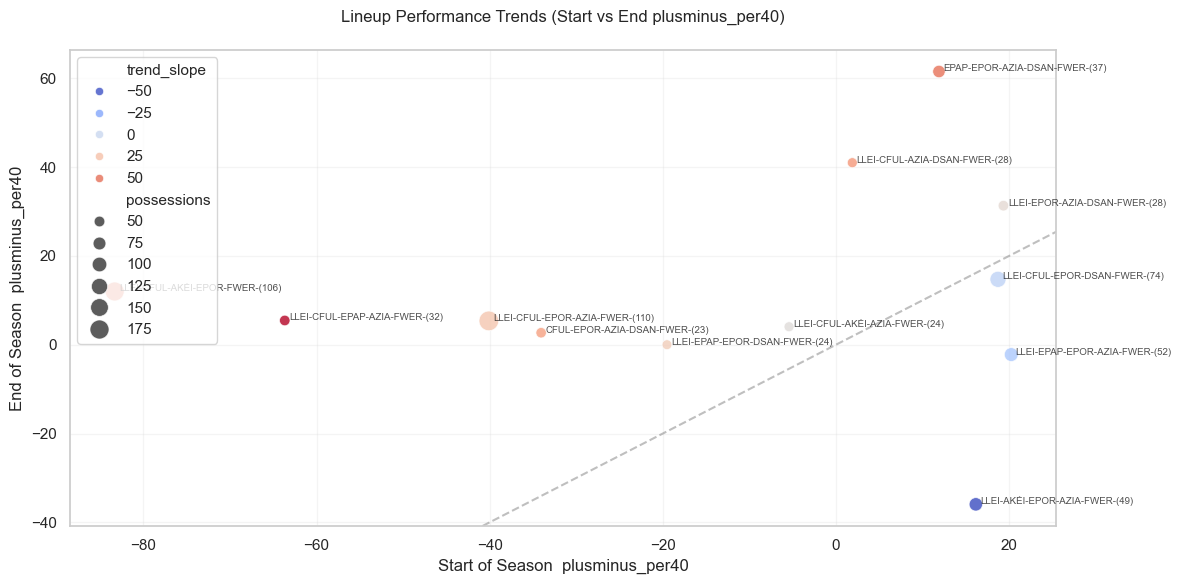

In [28]:
lineup_list = sorted(top_lineups['lineup'].unique())

if 'lineup_prog' in locals() and 'top_lineups' in locals():
    # Calculate trend slopes
    trends = []
    for lineup in lineup_list:
        df = lineup_prog[lineup_prog['lineup'] == lineup]
        if len(df) > 1:
            x = df['interval_num'].cat.codes
            y = df['plusminus_per40']
            slope = np.polyfit(x, y, 1)[0]
            trends.append({
                'lineup': lineup,
                'trend_slope': slope,
                'start_rating': df.iloc[0]['plusminus_per40'],
                'end_rating': df.iloc[-1]['plusminus_per40'],
                'minutes': df['minutes'].sum()
            })

    if trends:
        trend_df = pd.DataFrame(trends).merge(top_lineups, on='lineup')

        # ---- Create lineup_label just like in your heatmaps ----
        lineup_minutes_map = trend_df.set_index('lineup')['minutes_x'].to_dict()
        lineup_label_map = {
            lu: f"{'-'.join([p.upper() for p in lu.split('-')])}-({int(lineup_minutes_map[lu])})"
            for lu in trend_df['lineup']
        }
        trend_df['lineup_label'] = trend_df['lineup'].map(lineup_label_map)

        # ---- Plot with updated labels ----
        plt.figure(figsize=(12, 6))
        scatter = sns.scatterplot(
            data=trend_df,
            x='start_rating',
            y='end_rating',
            size='possessions',
            hue='trend_slope',
            sizes=(50, 200),
            palette='coolwarm',
            alpha=0.8
        )

        # Add reference line and labels
        plt.axline((0, 0), slope=1, linestyle='--', color='gray', alpha=0.5)
        for _, row in trend_df.iterrows():
            plt.text(row['start_rating'] + 0.5, row['end_rating'],
                     row['lineup_label'], fontsize=7, alpha=0.82)

        plt.title('Lineup Performance Trends (Start vs End plusminus_per40)', pad=20)
        plt.xlabel('Start of Season  plusminus_per40')
        plt.ylabel('End of Season  plusminus_per40')
        plt.grid(alpha=0.2)
        plt.tight_layout()
        plt.show()

    else:
        print("Insufficient data for trend analysis")
else:
    print("Required data not loaded")


## 5. Player Combinations Analysis
Which player pairs perform best together?

In [29]:
# %%

if 'top_lineups' in locals():
    # Extract player pairs
    player_combos = []
    for _, row in top_lineups.iterrows():
        players = row['lineup'].split('-')
        for i in range(len(players)):
            for j in range(i+1, len(players)):
                player_combos.append({
                    'player1': players[i],
                    'player2': players[j],
                    'plusminus_per40': row['plusminus_per40'],
                    'minutes': row['minutes']
                })
    
    combo_df = pd.DataFrame(player_combos)
    combo_df['minutes'] = combo_df['minutes'].round().astype(int)
    
    # Calculate pair performance
    top_pairs = (combo_df.groupby(['player1', 'player2'])
                 .agg({'plusminus_per40': 'mean', 'minutes': 'sum'})
                 .sort_values('minutes', ascending=False)
                 .head(15))
    combo_df['minutes'] = combo_df['minutes'].round().astype(int)
    
    # Display with styling
    display(top_pairs.style.background_gradient(
        subset=['plusminus_per40'],
        cmap='RdYlGn'
    ).format({'plusminus_per40': '{:.1f}'}))
else:
    print("Top lineups data not available")

In [30]:
if 'top_lineups' in locals():
    try:
        # Step 1: Get top 2 lineups by minutes
        top_2_lineups = top_lineups.groupby('lineup')['minutes'].sum().nlargest(2).index.tolist()
        #print(top_2_lineups)
        top_2_data = top_lineups[top_lineups['lineup'].isin(top_2_lineups)]

        # Step 2: Get players in top 2 lineups (in order, deduped)
        top_players_ordered = []
        for lu in top_2_lineups:
            top_players_ordered += lu.split('-')
        top_players_ordered = list(dict.fromkeys(top_players_ordered))  # Ordered unique
        print(f"Top players ordered: {top_players_ordered}")
        # Step 3: Build player pair combinations for all top_lineups
        player_combos = []
        for _, row in top_lineups.iterrows():
            players = row['lineup'].split('-')
            for i in range(len(players)):
                for j in range(i+1, len(players)):
                    player_combos.append({
                        'player1': players[i],
                        'player2': players[j],
                        'plusminus_per40': row['plusminus_per40'],
                        'minutes': row['minutes']
                    })
        combo_df = pd.DataFrame(player_combos)
        combo_df['minutes'] = combo_df['minutes'].round().astype(int)

        # Step 4: Aggregate across all appearances
        top_pairs = (
            combo_df.groupby(['player1', 'player2'])
            .agg({'plusminus_per40': 'mean', 'minutes': 'sum'})
            .reset_index()
        )

        # Step 5: Filter to pairs where at least one player is in top 2 lineups
        filtered_pairs = top_pairs[
            top_pairs['player1'].isin(top_players_ordered) &
            top_pairs['player2'].isin(top_players_ordered)
        ].copy()

        # Step 6: Optional sorting — by player1’s appearance order
        filtered_pairs['player1'] = pd.Categorical(filtered_pairs['player1'],
                                                   categories=top_players_ordered,
                                                   ordered=True)
        filtered_pairs = filtered_pairs.sort_values(['player1', 'minutes'], ascending=[True, False])

        # Step 7: Display
        display(
            filtered_pairs.style.background_gradient(
                subset=['plusminus_per40'], cmap='RdYlGn'
            ).format({'plusminus_per40': '{:.1f}'})
        )
        
    except Exception as e:
        print(f"Error processing filtered player pairs: {e}")
else:
    print("Top lineups data not available")



Top players ordered: ['LLEI', 'CFUL', 'EPOR', 'AZIA', 'FWER', 'AKÉI']


,player1,player2,plusminus_per40,minutes
25,LLEI,FWER,2.6,530
24,LLEI,EPOR,4.6,445
21,LLEI,CFUL,1.7,375
20,LLEI,AZIA,1.7,326
19,LLEI,AKÉI,4.6,180
10,CFUL,FWER,-0.0,398
9,CFUL,EPOR,1.6,313
6,CFUL,AZIA,-5.5,218
5,CFUL,AKÉI,5.2,131
18,EPOR,FWER,5.7,505
